In [1]:
#math
import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#interpolate
from scipy.integrate import quad

In [2]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 500
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=5,scale=5,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(500,)
(500, 2)
ModeResult(mode=array([0.]), count=array([45]))


In [3]:
beta0 = 1.
beta1 = .25

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.uniform.rvs(loc=-3,scale=6,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs

In [4]:
np.random.seed()
yn,xn,nobs = gen_data()

In [5]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y)
        
       
        #if complete case, assign pr missing to all observations...
        pr_m = stats.norm.logcdf( y, loc = mu_y)
        
        #we're done if ols
        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
        
    def score(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        m_x = np.repeat(m,x.shape[1]).reshape(x.shape)
        
        if ols: #if OLS use all the data...
            m, m_x = np.ones(y.shape), np.ones(x.shape)
        
        
        b = params

        beta_jac = np.zeros(len(b))
        
        #for censored
        if not ols: 
            left_stats = (y - np.dot(x, b)) 
            l_pdf = scipy.stats.norm.logpdf(left_stats)
            l_cdf = scipy.stats.norm.logcdf(left_stats)
            left_frac = np.exp(l_pdf - l_cdf)
            beta_left = np.dot(left_frac*m, x*m_x)
            beta_jac -= beta_left
        
        #for non-censored
        mid_stats = (y - np.dot(x, b))
        beta_mid = np.dot(mid_stats*(1-m), x*(1-m_x) )
        beta_jac += beta_mid
        
        # by chain rule, since the expression above is dloglik/dlogsigma
        return beta_jac



model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -1327.3
Model:                          Tobit   AIC:                             2659.
Method:            Maximum Likelihood   BIC:                             2668.
Date:                Thu, 25 Mar 2021                                         
Time:                        17:37:13                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9952      0.032     30.786      0.000       0.932       1.059
x1             0.2512      0.019     13.482      0.0

In [6]:
def print_params(model1,model2,beta0,beta1):
    print('\\begin{tabular}{|c|c|c|c|}')
    print('\\hline')
    print( 'Model  & $\\beta_0 = %.2f $ &  $\\beta_1 = %.2f $  \\\\ \\hline \\hline'%(beta0,beta1))
    print('Tobit & %.4f & %.4f \\\\'%(model1.params[0],model1.params[1]))
    print('{}&(%.3f)&(%.3f) \\\\'%(model1.bse[0],model1.bse[1]))
    print('\\hline')
    print('OLS & %.4f & %.4f \\\\'%(model2.params[0],model2.params[1]))
    print('{}&(%.3f)&(%.3f) \\\\'%(model2.bse[0],model2.bse[1]))
    print('\\hline')
    print('\\end{tabular}')


    
print_params(model1_fit,model2_fit,beta0,beta1)   

\begin{tabular}{|c|c|c|c|}
\hline
Model  & $\beta_0 = 1.00 $ &  $\beta_1 = 0.25 $  \\ \hline \hline
Tobit & 0.9952 & 0.2512 \\
{}&(0.032)&(0.019) \\
\hline
OLS & 1.0972 & 0.2075 \\
{}&(0.032)&(0.018) \\
\hline
\end{tabular}


# Create plots and stuff

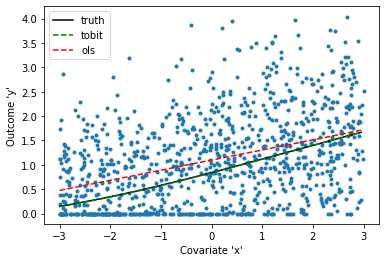

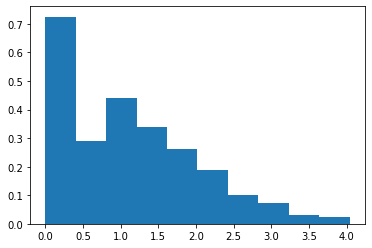

In [7]:
#create plot for true
plt.scatter(xn,yn,marker='.')
support_x = np.arange(xn.min(),xn.max(),.05)

#truth
pr_obs_true = stats.norm.cdf( beta0+beta1*support_x)
plt.plot(support_x, (beta0+beta1*support_x)*pr_obs_true ,label="truth",
         color='black')

#tobit
pr_obs_1 = stats.norm.cdf( model1_fit.params[0]+model1_fit.params[1]*support_x)
plt.plot(support_x, (model1_fit.params[0] + model1_fit.params[1]*support_x)*pr_obs_1 ,label="tobit",
         color='green',linestyle='--')

#ols
plt.plot(support_x, model2_fit.params[0] + model2_fit.params[1]*support_x ,label="ols",
         color='red',linestyle='--')



#create plot for normal
plt.ylabel("Outcome 'y'")
plt.xlabel("Covariate 'x'")
plt.legend()
#plt.savefig('../figs/tobit_%s.png'%int(beta1*100))
plt.show()

plt.hist(yn,density=True)
plt.show()

# Do counterfactuals

In [63]:
def marginal_effect(beta0,beta1,sigma,x):
    mux = beta0+beta1*x
    return stats.norm.cdf(mux/np.sqrt(np.abs(sigma)))*beta1

def avg_effect(beta0,beta1,sigma):
    integrand = lambda x: marginal_effect(beta0,beta1,sigma,x)*stats.norm(loc=5,scale=5).pdf(x)
    I = quad(integrand, -100,100)
    return I

def counterfactual_table(model1,model2):
    beta0,beta1 = model1.params[0],model1.params[1]
    a1 = avg_effect(beta0,beta1,1)[0]
    a2 = model2.params[1]
    m2 = model2.params[1]  

    
    m1s = []
    m1s_percent = []
    for x in [-3,0,3]:
        m1 = marginal_effect(beta0,beta1,1,x)
        m1s.append(m1)
        m1s_percent.append(int( 100*(m1-m2)/m1) )
        
    percents = tuple(m1s_percent + [int((a1-a2)/a1*100)])
    m1s = m1s + [a1]
    print('\\begin{tabular}{|c|c|c|c||c|}')
    print('\\hline')
    print('Model  & x = -3 & x = 0 & x = 3 & Avg \\\\ \\hline \\hline ')  
    print('Tobit & %.4f & %.4f &  %.4f & %.4f \\\\ \\hline'%tuple(m1s))
    print('OLS & %.4f & %.4f &  %.4f & %.4f \\\\ \\hline \\hline'%tuple(4*[m2]))
    print('\\%% change & %s \\%% & %s \\%% & %s \\%% & %s \\%% \\\\ \\hline'%tuple(percents))
    print('\\end{tabular}')
    
counterfactual_table(model1_fit,model2_fit)

\begin{tabular}{|c|c|c|c||c|}
\hline
Model  & x = -3 & x = 0 & x = 3 & Avg \\ \hline \hline 
Tobit & 0.1419 & 0.2054 &  0.2383 & 0.2283 \\ \hline
OLS & 0.2291 & 0.2291 &  0.2291 & 0.2291 \\ \hline \hline
\% change & -61 \% & -11 \% & 3 \% & 0 \% \\ \hline
\end{tabular}


In [64]:
print('\%')

\%
